In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
files
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['/kaggle/input/digit-recognizer/sample_submission.csv',
 '/kaggle/input/digit-recognizer/train.csv',
 '/kaggle/input/digit-recognizer/test.csv']

In [2]:
train_df = pd.read_csv(files[1])
test_df = pd.read_csv(files[2])
train_df.head(), test_df.head()

(   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
 0      1       0       0       0       0       0       0       0       0   
 1      0       0       0       0       0       0       0       0       0   
 2      1       0       0       0       0       0       0       0       0   
 3      4       0       0       0       0       0       0       0       0   
 4      0       0       0       0       0       0       0       0       0   
 
    pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0         0         0         0   
 3       0  ...         0         0         0         0         0         0   
 4       0  ...         0         0         0         0         0         0   
 
    pixel780  pixel781  pixel782  pixel783  
 0         0   

In [3]:
y_train = train_df['label'].values
x_train = train_df.drop(['label'],axis=1).values.astype('float32')
x_test = test_df.values.astype('float32')

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: >]


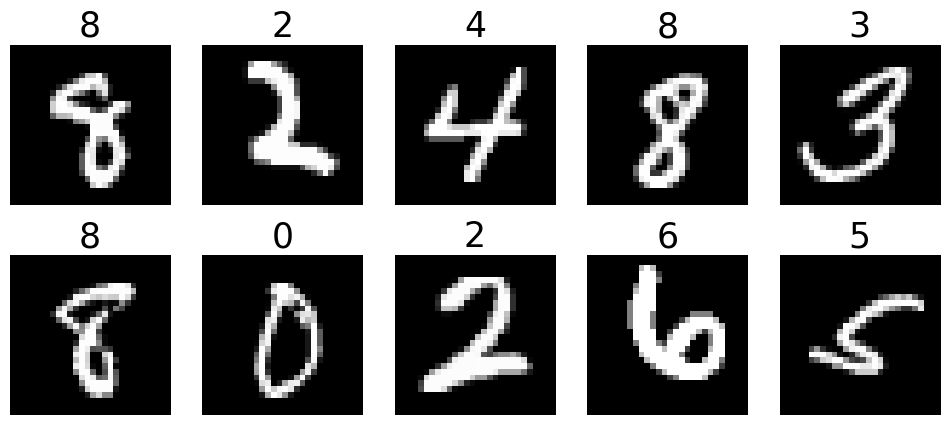

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
print(axes)
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
x_train = x_train.reshape(42000, 28, 28, 1)
x_test = x_test.reshape(28000, 28, 28, 1)

In [7]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)

In [8]:
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

In [9]:
train_images.shape, valid_images.shape, train_labels.shape, valid_labels.shape

((33600, 28, 28, 1), (8400, 28, 28, 1), (33600, 10), (8400, 10))

[0 1 0 0 0 0 0 0 0 0]


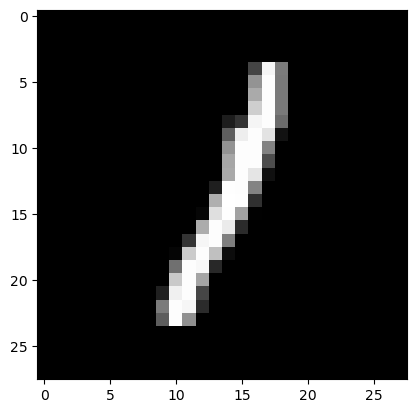

In [10]:
idx = 16
plt.imshow(train_images[idx,:,:,:].reshape(28, 28), cmap='gray')
print(train_labels[idx, :])
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_datagen.fit(train_images)
train_generator = train_datagen.flow(x=train_images,
                                       y=train_labels,
                                       batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow(x=valid_images,
                                                 y=valid_labels,
                                                 batch_size=32)

In [12]:
print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (33600, 28, 28, 1)
Labels of training generator have shape: (33600, 10)
Images of validation generator have shape: (8400, 28, 28, 1)
Labels of validation generator have shape: (8400, 10)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers,models
def my_model():
    model = models.Sequential([
        layers.Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(32,(3,3),activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.Dense(10,activation='softmax')
    ])
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model

In [14]:
import tensorflow as tf
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_weights.h5', 
                                                        save_best_only=True,  # Save only the best weights
                                                        save_weights_only=True,  # Save only the weights, not the entire model
                                                        monitor='val_loss',  # You can monitor a different metric if needed
                                                        mode='min',  # Save the weights when the monitored metric is minimized
                                                        verbose=1)

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [16]:
model = my_model()
# Train your model
with tf.device('GPU:0'):
    history = model.fit(train_generator,
                    epochs=35,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback])
#history.log()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

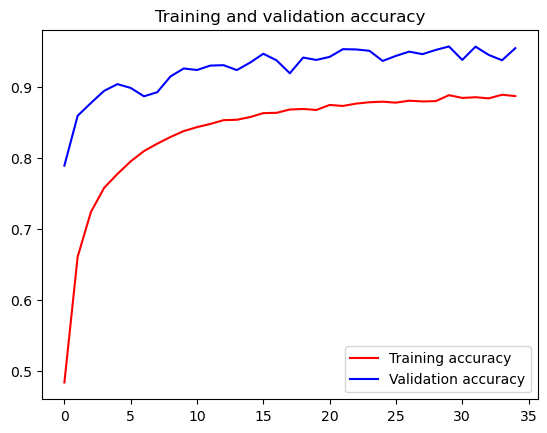

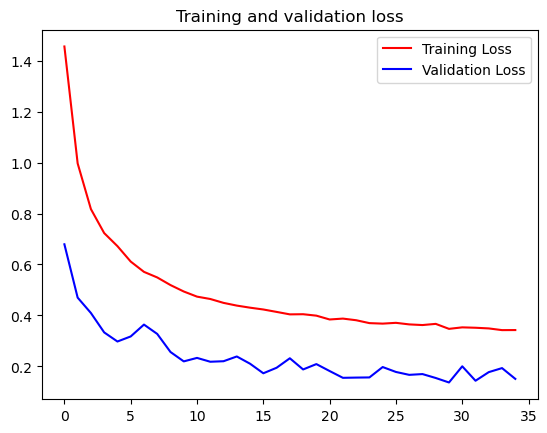

In [17]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [18]:
test_predictions = model.predict(x_test)


875/875 [==============================] - 1s 2ms/step


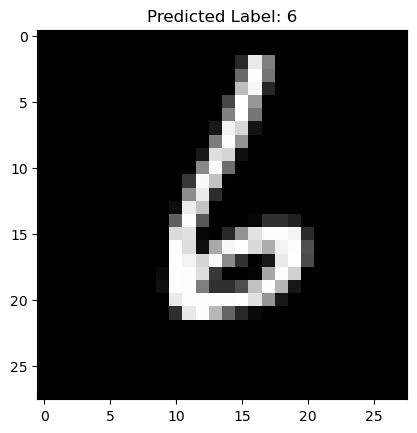

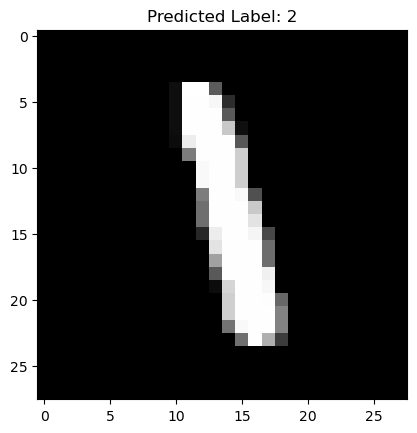

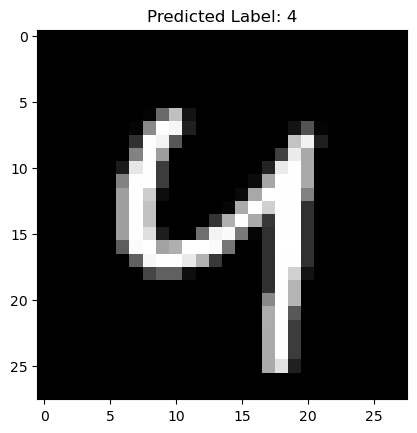

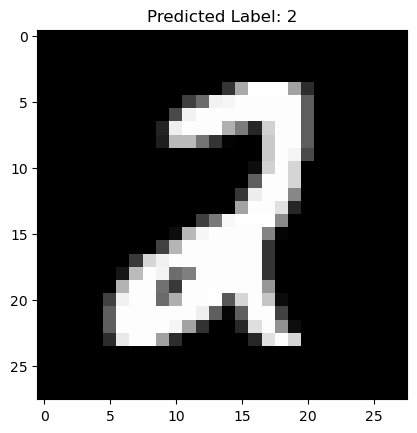

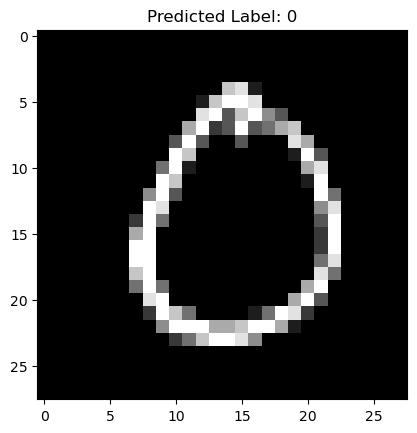

In [19]:
import random
import matplotlib.pyplot as plt

# Randomly select some samples
sample_indices = random.sample(range(len(x_test)), 5)

for idx in sample_indices:
    image = x_test[idx]  # Assuming 'test_data' is a list of images
    predicted_labels = test_predictions[idx]  # Corresponding predicted label
    predicted_label = np.argmax(predicted_labels)
    # Display the image and predicted label
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted Label: {predicted_label}')
    plt.show()


In [20]:
import pickle
model.load_weights('model_weights.h5')

# Now, you can save the model weights to a pickle file
with open('model_weights.pkl', 'wb') as file:
    pickle.dump(model.get_weights(), file)
